<a href="https://colab.research.google.com/github/omararh/Expression-editor-assistant/blob/main/RE_TRY_API_MISTRAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json

def read_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    return json.load(f)

INPUT_DATA_BASE_PATH = 'input_data/'

AVAILABLE_CONTEXT = read_file(INPUT_DATA_BASE_PATH + 'context.json')

SYMFONY_EXAMPLES = read_file(INPUT_DATA_BASE_PATH + 'examples.json')

# NLP :

Cette partie va nous servir pour vérifier a quel point les réponses de l'API sont valide (précision).

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import spacy
!python -m spacy download fr_core_news_md

tokenizer = spacy.load('fr_core_news_md')

def normalized_text_embedding(text):
    """
        Calcule l'embedding normalisé du texte pour que la longueur des phrases n'influence
        pas les comparaisons de similarité, en se concentrant uniquement sur leur sens.

        :param text: input string
        :return: vector (text embedding)
    """
    tokens = tokenizer(text)
    # vectors: matrice ou chaqye ligne représente l'embedding d'un token
    vectors = np.array([
        token.vector for token in tokens
        if token.has_vector and not token.is_stop and not token.is_punct # check token validity
    ])

    if vectors.size == 0:
        raise ValueError(f"No valid embedding could be generated for text: '{text}'")

    avg_vector = np.mean(vectors, axis=0)
    norm = np.linalg.norm(avg_vector) # norme euclidienne : une représentation de la longeur du vecteur (text) -> float

    if norm == 0:
        raise ValueError(f"Zero norm embedding for text: '{text}'")

    return avg_vector / norm # normalisation = vect / norme_euclidienne

def filter_by_embedding(input, dict, top_k=5):
    """
    return K relevant examples from the examples list
    Args:
        input: user request
        dict: (description -> key) examples
        top_k: K relevant examples to be returned

    Returns:
        K relevant examples
    """
    input_embedding = normalized_text_embedding(input)

    similarities = []

    for description, key in dict.items():
        desc_embedding = normalized_text_embedding(description)

        similarity = cosine_similarity([input_embedding], [desc_embedding])[0][0]
        similarities.append((similarity, description, key))

    similarities.sort(reverse=True)
    top_examples = [(desc, expr) for _, desc, expr in similarities[:top_k]]

    return top_examples

def calculate_similarity(expected, generated):
    """
      Calculate the similarity percentage between the `expected` and the `generated` expressions.
      :param expected: string
      :param generated: string
      :return: similarity score (float between 0 and 1)
    """
    if expected.strip() == generated.strip():
        return 1.0

    expected_embedding = normalized_text_embedding(expected)
    generated_embedding = normalized_text_embedding(generated)

    """ ### cosine_similarity: Fais une comparaison entre vecteurs ###
        1 = les vecteurs sont identiques → les phrases ont le même sens.
        0 = aucun rapport entre les deux.
        -1 = totalement opposés (rare ici).
    """
    return float(cosine_similarity([expected_embedding], [generated_embedding])[0][0])


# API call
ici on a un ensemble de fonctions qui vont nous servir a un préparer le
prompt puis faire la call API et en suite extraire la réponse.

In [32]:
import requests
from google.colab import userdata

# Configuration de l'API
API_URL = "https://api.mistral.ai/v1/chat/completions"
API_KEY = userdata.get('API_KEY')

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

def generate_expression(user_intent, available_context=None, examples=None):
    prompt = _build_prompt(user_intent, available_context, examples)

    try:
        return _generate_with_api(prompt)
    except Exception as e:
        print(f"Erreur: {e}")
        return "Une erreur est survenue."

def _build_prompt(user_intent, available_context=None, examples=None):
    """Construit un prompt clair et minimaliste pour le modèle"""
    prompt = (
        "Tu es un assistant expert en Symfony Expression Language. "
        "Ta tâche est de générer une **seule** expression Symfony valide, sans aucune explication, "
        "en te basant uniquement sur le contexte et les exemples fournis.\n\n"
    )

    # Contexte disponible
    if available_context:
        prompt += "Contexte :\n"
        for category, items in available_context:
            if isinstance(items, dict):
                prompt += f"- {category} :\n"
                for key, value in items.items():
                    prompt += f"  * {key}: {value}\n"
            else:
                prompt += f"- {category} : {', '.join(items)}\n"
        prompt += "\n"

    # Exemples pertinents
    if examples:
        prompt += "Exemples :\n"
        for description, expression in examples:
            prompt += f"Demande : {description}\n"
            prompt += f"Expression : {expression}\n\n"

    # Ajout de l'intention actuelle de l'utilisateur
    prompt += f"Demande : {user_intent.strip()}\n"
    prompt += "Expression :"

    return prompt

def _generate_with_api(prompt):
    payload = {
        "model": "mistral-large-latest",
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.1,
        "max_tokens": 100
    }

    response = requests.post(API_URL, headers=headers, json=payload)

    if response.status_code == 200:
        result = response.json()
        response_content = result["choices"][0]["message"]["content"]
        return _extract_response(response_content)
    else:
        raise Exception(f"Erreur API: {response.status_code} - {response.text}")

def _extract_response(response_content):
    """Extrait la partie pertinente de la réponse"""
    # Recherche spécifiquement l'expression après "Expression :"
    if "Expression :" in response_content:
        # Extrait tout ce qui suit le dernier "Expression :"
        parts = response_content.split("Expression :")
        response_content = parts[-1].strip()

    # Supprime tout ce qui pourrait suivre l'expression (comme "Demande :")
    if "Demande :" in response_content:
        response_content = response_content.split("Demande :")[0].strip()

    # Supprime les guillemets s'ils sont présents
    response_content = response_content.strip('"\'')

    # Supprime les lignes supplémentaires s'il y en a
    if "\n" in response_content:
        response_content = response_content.split("\n")[0].strip()

    return response_content

# First prompt

In [33]:
user_question = "Pour chaque ligne, retourner false si 'key_response' est égal à 'LIST_OUI_NON_NON' ou si 'key_response' est null, sinon retourner true"


filtred_examples = filter_by_embedding(user_question, {v: k for k, v in SYMFONY_EXAMPLES.items()}, top_k=10)
filtred_context = filter_by_embedding(user_question, {v: k for k, v in AVAILABLE_CONTEXT.items()}, top_k=5)

expression = generate_expression(
    user_question,
    available_context=filtred_context,
    examples=filtred_examples
)
print(f"Expression générée: {expression}")

Expression générée: row.key_response != 'LIST_OUI_NON_NON' and row.key_response != null


# Test

Pour évaluer la précision et la performance des API de modèles de langage (LLM), nous n'utilisons pas un systéme par EPOCHs (avec plusieurs exécutions suivies d'une moyenne des résultats), car les appels aux API peuvent être influencés par un mécanisme de cache.
Cela signifie que répéter plusieurs fois la même requête peut donner des réponses plus rapides (grâce au cache), ce qui fausserait les mesures de performance réelles. Par conséquent, nous préférons analyser les résultats à partir d'une seule exécution par requête afin d’obtenir une évaluation plus représentative des conditions d'utilisation réelles.

### Précision

Époque 1/1...
Précision: 81.25%
Époque terminée en 31.85s

Temps total: 31.85s
Taux de correspondance moyen: 81.25%
Similarité moyenne: 77.64%


,query,expected,best_generated,avg_similarity,match_rate
0,Vérifier si le nom d'utilisateur est égal à 't...,legacyContext.contextVar.userName == 'toto',userUsername == 'toto,1.000000,1.0
1,Exécuter le modèle 'IPC_USER_PROFILE' et si le...,getModelValue('IPC_USER_PROFILE') || false,IPC_USER_PROFILE ?? false,0.790477,1.0
2,Vérifier si l'utilisateur peut mettre à jour l...,documentAccessUpdateData() and today() == '200...,"```documentAccessUpdateData and ""now""|date(""d/...",0.370777,0.0
3,Vérifier si l'email de l'utilisateur contient ...,legacyContext.contextVar.userEmail matches '/@...,user.email contains '@internal.org,0.059019,0.0
4,"Pour chaque ligne du document, vérifier si le ...",row.status == 'pending',document.status == 'pending,1.000000,1.0
5,Vérifier si l'utilisateur est un manager et pe...,"inArray('manager', legacyContext.contextVar.us...",user.isManager() and documentMassUpdateData,1.000000,1.0
6,Vérifier si l'email suit le format prenom.nom@...,legacyContext.contextVar.userEmail matches '/^...,userEmail matches '/^[a-zA-Z]+\\.[a-zA-Z]+@[a-...,0.140689,0.0
7,Vérifier si la langue courante est le français...,legacyContext.contextVar.currentLanguage in ['...,"currentLanguage in ['fr', 'en', 'es']",1.000000,1.0
8,Vérifier si l'utilisateur a plus de 3 niveaux ...,legacyContext.contextVar.userAccessLevels|leng...,userAccessLevels|length > 3,1.000000,1.0
9,"Pour chaque ligne, vérifier si le statut est '...","row.status in ['active', 'pending'] and isEmpt...","line.status in ['active', 'pending'] and isEmp...",1.000000,1.0


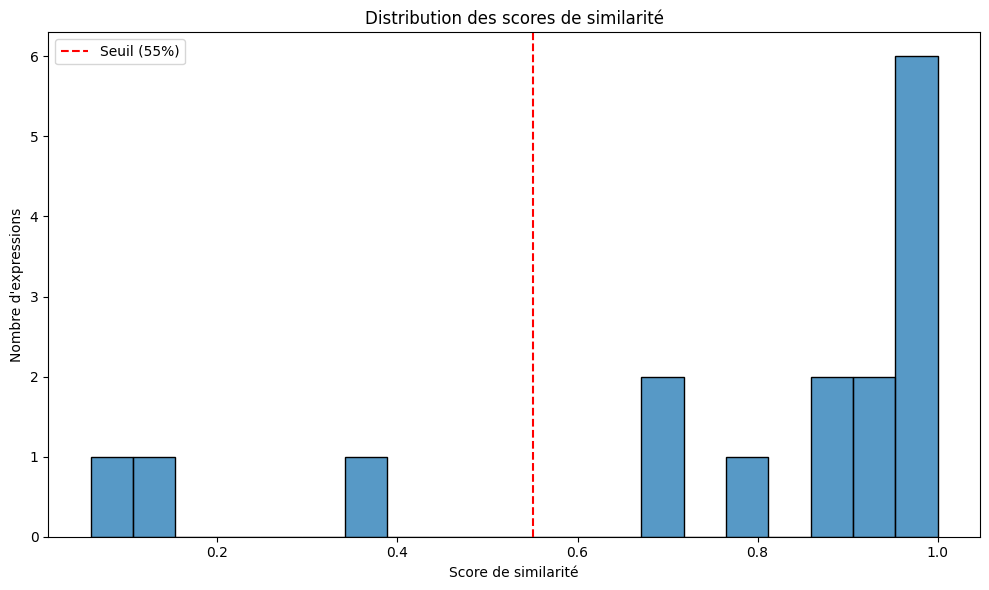

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

TEST_RESULTS_PATH = "testResults/GRATUITE_S_PP/"

def setup_test_dir():
    """Crée le répertoire de résultats"""
    os.makedirs(TEST_RESULTS_PATH, exist_ok=True)

def process_test_case(test, context, examples, similarity_threshold):
    """
    Traite un cas de test unique

    Args:
        test: Le cas de test à traiter
        context: Le contexte disponible
        examples: Les exemples d'expressions
        similarity_threshold: Seuil de similarité

    Returns:
        dict: Résultat du test
    """
    # Génération et mesure du temps
    start_time = time.time()
    try:
        generated = generate_expression(
            test['query'],
            available_context=context,
            examples=examples
        )
    except Exception as e:
        print(f"Erreur: {str(e)[:100]}...")
        generated = "Erreur API"

    execution_time = time.time() - start_time

    # Calcul des métriques
    similarity = calculate_similarity(test['expected'], generated)
    is_match = similarity >= similarity_threshold

    # Construction du résultat
    return {
        'query': test['query'],
        'expected': test['expected'],
        'generated': generated,
        'similarity': similarity,
        'is_match': is_match,
        'execution_time': execution_time
    }

def write_result_to_file(f, result):
    """
    Écrit un résultat dans un fichier

    Args:
        f: Le fichier ouvert en écriture
        result: Le résultat à écrire
    """
    f.write(f"Query: {result['query']}\n")
    f.write(f"Expected: {result['expected']}\n")
    f.write(f"Generated: {result['generated']}\n")
    f.write(f"Similarité: {result['similarity']:.2%}\n")
    f.write(f"Résultat: {'✅ Match' if result['is_match'] else '❌ No Match'}\n\n")

def calculate_epoch_metrics(epoch_results):
    """
    Calcule les métriques pour une époque

    Args:
        epoch_results: Les résultats de l'époque

    Returns:
        float: Le taux de correspondance
    """
    epoch_df = pd.DataFrame(epoch_results)
    return epoch_df['is_match'].mean() if not epoch_df.empty else 0

def generate_visualizations(all_results, epoch_times, similarity_threshold, epochs):
    """
    Génère les visualisations des résultats

    Args:
        all_results: Tous les résultats de test
        epoch_times: Temps d'exécution par époque
        similarity_threshold: Seuil de similarité
        epochs: Nombre d'époques
    """
    all_df = pd.DataFrame(all_results)

    # 1. Graphique de distribution des similarités
    plt.figure(figsize=(10, 6))
    sns.histplot(data=all_df, x='similarity', bins=20)
    plt.axvline(x=similarity_threshold, color='red', linestyle='--',
                label=f'Seuil ({similarity_threshold:.0%})')
    plt.title('Distribution des scores de similarité')
    plt.xlabel('Score de similarité')
    plt.ylabel("Nombre d'expressions")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{TEST_RESULTS_PATH}distribution_similarite.png")

def calculate_average_results(query_results):
    """
    Calcule les résultats moyens par requête

    Args:
        query_results: Dictionnaire des résultats par requête

    Returns:
        DataFrame: Résultats moyens
    """
    avg_results = []

    for query, results in query_results.items():
        # Trouver le meilleur résultat
        best_result = max(results, key=lambda x: x['similarity'])

        # Calculer les moyennes
        similarities = [r['similarity'] for r in results]
        is_matches = [r['is_match'] for r in results]

        avg_results.append({
            'query': query,
            'expected': best_result['expected'],
            'best_generated': best_result['generated'],
            'avg_similarity': np.mean(similarities),
            'match_rate': np.mean(is_matches)
        })

    return pd.DataFrame(avg_results)

def run_tests(context, examples, similarity_threshold=0.55, epochs=5):
    setup_test_dir()

    all_results = []
    epoch_times = []
    start_total = time.time()

    query_results = {}

    for epoch in range(1, epochs + 1):
        print(f"Époque {epoch}/{epochs}...")
        start_epoch = time.time()

        epoch_results = []
        with open(f"{TEST_RESULTS_PATH}resultats_epoch_{epoch}.txt", "w", encoding="utf-8") as f:
            for test in test_cases:
                user_query = test['query']

                # Contexte et exemples filtrés dynamiquement
                filtred_examples = filter_by_embedding(user_query, {v: k for k, v in examples.items()}, top_k=10)
                filtred_context = filter_by_embedding(user_query, {v: k for k, v in context.items()}, top_k=5)

                result = process_test_case(
                    test, filtred_context, filtred_context, similarity_threshold
                )

                query = test['query']
                if query not in query_results:
                    query_results[query] = []
                query_results[query].append(result)

                all_results.append(result)
                epoch_results.append(result)

                write_result_to_file(f, result)

        duration = time.time() - start_epoch
        epoch_times.append(duration)

        match_rate = calculate_epoch_metrics(epoch_results)
        print(f"Précision: {match_rate:.2%}")
        print(f"Époque terminée en {duration:.2f}s\n")

    total_time = time.time() - start_total
    print(f"Temps total: {total_time:.2f}s")

    avg_df = calculate_average_results(query_results)
    avg_df.to_csv(f"{TEST_RESULTS_PATH}resultats_moyens.csv", index=False)

    print(f"Taux de correspondance moyen: {avg_df['match_rate'].mean():.2%}")
    print(f"Similarité moyenne: {avg_df['avg_similarity'].mean():.2%}")

    generate_visualizations(all_results, epoch_times, similarity_threshold, epochs)

    return avg_df

# Utilisation
test_cases = read_file('test_data/test_cases.json')
run_tests(AVAILABLE_CONTEXT, SYMFONY_EXAMPLES, epochs=1)

Requête 1/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no attribute 'items'
Requête 2/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no attribute 'items'
Requête 3/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no attribute 'items'
Requête 4/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no attribute 'items'
Requête 5/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no attribute 'items'
Requête 6/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no attribute 'items'
Requête 7/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no attribute 'items'
Requête 8/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no attribute 'items'
Requête 9/16...
Erreur: 'list' object has no attribute 'items'...
Erreur: 'list' object has no a

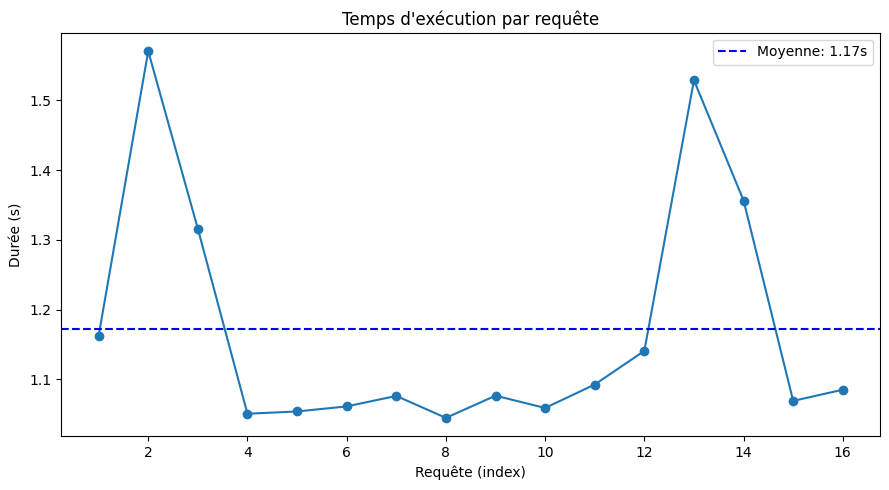

In [18]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

TEST_RESULTS_PATH = "testResults/"

def run_performance_test(context, examples, similarity_threshold=0.55):
    """
    Exécute un test de performance simple (1 requête = 1 test) et trace les temps d'exécution.

    Args:
        context (dict): Contexte disponible
        examples (dict): Exemples d'expressions
        similarity_threshold (float): Seuil de similarité

    Returns:
        float: Temps moyen par requête
    """
    setup_test_dir()

    individual_times = []

    for i, test in enumerate(test_cases):
        print(f"Requête {i + 1}/{len(test_cases)}...")

        start = time.time()

        user_query = test['query']
        filtred_examples = filter_by_embedding(user_query, {v: k for k, v in examples.items()}, top_k=10)
        filtred_context = filter_by_embedding(user_query, {v: k for k, v in context.items()}, top_k=5)

        result = process_test_case(
            test, filtred_context, filtred_examples, similarity_threshold
        )

        try:
            generate_expression(test['query'], available_context=filtred_context, examples=filtred_examples)
        except Exception as e:
            print(f"Erreur: {str(e)}")

        elapsed = time.time() - start
        individual_times.append(elapsed)

    avg_time = np.mean(individual_times)
    print(f"Temps moyen par requête: {avg_time:.2f}s")

    # Tracer les temps d'exécution
    plot_execution_times(individual_times)

    return avg_time


def plot_execution_times(times):
    """
    Trace les temps d'exécution par requête avec une ligne de moyenne.

    Args:
        times (list): Liste des durées en secondes
    """
    plt.figure(figsize=(9, 5))
    plt.plot(range(1, len(times) + 1), times, marker='o', linestyle='-')
    avg_time = np.mean(times)
    plt.axhline(y=avg_time, color='blue', linestyle='--', label=f'Moyenne: {avg_time:.2f}s')
    plt.title("Temps d'exécution par requête")
    plt.xlabel("Requête (index)")
    plt.ylabel("Durée (s)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{TEST_RESULTS_PATH}temps_par_requete.png")
    plt.show()

# Exécution du test de performance
avg_time = run_performance_test(AVAILABLE_CONTEXT, SYMFONY_EXAMPLES)